## Equipe : Raul Aquino e Wendell

#### Material de apoio

https://www.youtube.com/watch?v=WEV61GmmPrk

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

https://www.kaggle.com/rjtmehta99/e-d-a-of-chennai-hotel-reviews

https://github.com/IFCE-Mestado-Ciencia-da-Computacao/PGM-2017.2/blob/master/Lista-2.ipynb

In [1]:
#Imports
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import enchant
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Download to complement vocabulary creation 
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [2]:
#RNN class where the model for this problem will be created.
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
#Loading the dataset in df
df = pd.read_csv('./chennai_reviews.csv')
#Showing the dataset's inconsistencies
print(df.shape)
df.head()

(4768, 9)


,Hotel_name,Review_Title,Review_Text,Sentiment,Rating_Percentage,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Accord Metropolitan,Excellent comfortableness during stay,Its really nice place to stay especially for b...,3,100,NaN,NaN,NaN,NaN
1,Accord Metropolitan,Not too comfortable,It seems that hotel does not check the basic a...,1,20,NaN,NaN,NaN,NaN
2,Accord Metropolitan,NaN,Worst hotel I have ever encountered. I will ne...,1,20,NaN,NaN,NaN,NaN
3,Accord Metropolitan,Best hotel,Had a good time in this hotel and the staff Ku...,3,100,NaN,NaN,NaN,NaN
4,Accord Metropolitan,NaN,good hotel and staff Veg food good non veg bre...,3,100,NaN,NaN,NaN,NaN


In [4]:
#Showing information about the dataset and seeing its inconsistencies
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768 entries, 0 to 4767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Hotel_name         4768 non-null   object 
 1   Review_Title       4341 non-null   object 
 2   Review_Text        4767 non-null   object 
 3   Sentiment          4766 non-null   object 
 4   Rating_Percentage  4767 non-null   object 
 5   Unnamed: 5         64 non-null     float64
 6   Unnamed: 6         3 non-null      object 
 7   Unnamed: 7         1 non-null      float64
 8   Unnamed: 8         1 non-null      float64
dtypes: float64(3), object(6)
memory usage: 335.4+ KB


In [5]:
#Remove noisy data from column 6,7,8,9
#Remove the columns that have 'unnamed' in the column name
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,Hotel_name,Review_Title,Review_Text,Sentiment,Rating_Percentage
0,Accord Metropolitan,Excellent comfortableness during stay,Its really nice place to stay especially for b...,3,100
1,Accord Metropolitan,Not too comfortable,It seems that hotel does not check the basic a...,1,20
2,Accord Metropolitan,NaN,Worst hotel I have ever encountered. I will ne...,1,20
3,Accord Metropolitan,Best hotel,Had a good time in this hotel and the staff Ku...,3,100
4,Accord Metropolitan,NaN,good hotel and staff Veg food good non veg bre...,3,100
...,...,...,...,...,...
4763,Hyatt Regency Chennai,Fifth stay and excellent as always,My fifth stay at the hotel for business. Rooms...,3,100
4764,Hyatt Regency Chennai,satisfied,enjoyable,3,100
4765,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,3,80
4766,Hyatt Regency Chennai,Dissappointed,"The linens were smelling bad, and the elevator...",1,20


In [6]:
#Replace empty cells with 'Unavailable' in Review_Title column 
values = {'Review_Text': 'Unavailable'}
df = df.fillna(value=values)
df

,Hotel_name,Review_Title,Review_Text,Sentiment,Rating_Percentage
0,Accord Metropolitan,Excellent comfortableness during stay,Its really nice place to stay especially for b...,3,100
1,Accord Metropolitan,Not too comfortable,It seems that hotel does not check the basic a...,1,20
2,Accord Metropolitan,NaN,Worst hotel I have ever encountered. I will ne...,1,20
3,Accord Metropolitan,Best hotel,Had a good time in this hotel and the staff Ku...,3,100
4,Accord Metropolitan,NaN,good hotel and staff Veg food good non veg bre...,3,100
...,...,...,...,...,...
4763,Hyatt Regency Chennai,Fifth stay and excellent as always,My fifth stay at the hotel for business. Rooms...,3,100
4764,Hyatt Regency Chennai,satisfied,enjoyable,3,100
4765,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,3,80
4766,Hyatt Regency Chennai,Dissappointed,"The linens were smelling bad, and the elevator...",1,20


In [7]:
#Replace noisy data in column Sentiment with column mean value
df['Sentiment'] = df['Sentiment'].str.replace(r'[^1-9]','')

#Remove white spaces
df['Sentiment'] = df['Sentiment'].str.replace(r'[s+]','')

#Fill missing values
df['Sentiment'] = df['Sentiment'].fillna(2)
df

,Hotel_name,Review_Title,Review_Text,Sentiment,Rating_Percentage
0,Accord Metropolitan,Excellent comfortableness during stay,Its really nice place to stay especially for b...,3,100
1,Accord Metropolitan,Not too comfortable,It seems that hotel does not check the basic a...,1,20
2,Accord Metropolitan,NaN,Worst hotel I have ever encountered. I will ne...,1,20
3,Accord Metropolitan,Best hotel,Had a good time in this hotel and the staff Ku...,3,100
4,Accord Metropolitan,NaN,good hotel and staff Veg food good non veg bre...,3,100
...,...,...,...,...,...
4763,Hyatt Regency Chennai,Fifth stay and excellent as always,My fifth stay at the hotel for business. Rooms...,3,100
4764,Hyatt Regency Chennai,satisfied,enjoyable,3,100
4765,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,3,80
4766,Hyatt Regency Chennai,Dissappointed,"The linens were smelling bad, and the elevator...",1,20


In [8]:
#Taking the average of the correct values that are [1,2,3]
aux = 0
for i in range(len(df.Sentiment)):
    if (df.Sentiment[i] != '' and int(df.Sentiment[i]) <= 3):
        aux += int(df.Sentiment[i])
aux = round(aux/len(df.Sentiment))
print(aux)

3


In [9]:
#Leaving all variables in the string pattern.
for i in range(len(df.Sentiment)):
    form = 0
    if df.Sentiment[i] == '':
        df.Sentiment[i] = str(aux)
        
#Leaving all ratings in lower case.
df['Review_Text'] = df['Review_Text'].apply(lambda x:x.lower())

In [10]:
#Changing all values outside the pattern to the rounded average of the data.
for i in range(len(df.Sentiment)):
    if int(df.Sentiment[i]) > 3:
        df.Sentiment[i] = str(aux)

In [11]:
#Removing columns that are not needed
df = df.drop(['Hotel_name', 'Review_Title'], axis=1)
df.head()

,Review_Text,Sentiment,Rating_Percentage
0,its really nice place to stay especially for b...,3,100
1,it seems that hotel does not check the basic a...,1,20
2,worst hotel i have ever encountered. i will ne...,1,20
3,had a good time in this hotel and the staff ku...,3,100
4,good hotel and staff veg food good non veg bre...,3,100


In [12]:
# Find word index from all_letters, e.g. "a" = 0
def wordToIndex(word):
    return np.where(all_words == word)[0][0]

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def wordToTensor(word):
    tensor = torch.zeros(1, len(all_words))
    tensor[0][wordToIndex(word)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, len(all_words))
    for li, word in enumerate(line):
        tensor[li][0][wordToIndex(word)] = 1
    return tensor

In [13]:
#Convert to lower case
def preprocess(column_name):
    column_name = column_name.str.lower()
    column_name = column_name.str.replace(r"^[a-zA-Z]\s+","")
    column_name = column_name.str.replace(r"wouldn't","would not")
    column_name = column_name.str.replace(r"ain't","am not")
    column_name = column_name.str.replace(r"isn't","is not")
    column_name = column_name.str.replace(r"aren't","are not")
    column_name = column_name.str.replace(r"can't","can not")
    column_name = column_name.str.replace(r"shouldn't","should not")
    column_name = column_name.str.replace(r"shan't","shall not")
    column_name = column_name.str.replace(r"won't","will not")
    column_name = column_name.str.replace(r"hasn't","has not")
    column_name = column_name.str.replace(r"hadn't","had not")
    column_name = column_name.str.replace(r"don't","do not")
    column_name = column_name.str.replace(r"couldn't","could not")
    column_name = column_name.str.replace(r"didn't","did not")
    column_name = column_name.str.replace(r"aint","am not")
    column_name = column_name.str.replace(r"isnt","is not")
    column_name = column_name.str.replace(r"wouldnt","would not")
    column_name = column_name.str.replace(r"aint","am not")
    column_name = column_name.str.replace(r"isnt","is not")
    column_name = column_name.str.replace(r"arent","are not")
    column_name = column_name.str.replace(r"cant","can not")
    column_name = column_name.str.replace(r"shouldnt","should not")
    column_name = column_name.str.replace(r"shant","shall not")
    column_name = column_name.str.replace(r"wont","will not")
    column_name = column_name.str.replace(r"hasnt","has not")
    column_name = column_name.str.replace(r"hadnt","had not")
    column_name = column_name.str.replace(r"dont","do not")
    column_name = column_name.str.replace(r"couldnt","could not")
    column_name = column_name.str.replace(r"didnt","did not")
    column_name = column_name.str.replace(r"aint","am not")
    column_name = column_name.str.replace(r"isnt","is not")    

    return column_name

In [14]:
#Applying the function
df.Review_Text = preprocess(df.Review_Text)

In [15]:
#Separating the columns and checking if they are the same size.
review_text = df.Review_Text
sentiment = df.Sentiment
print(len(review_text), len(sentiment))
print(len(review_text) == len(sentiment))

4768 4768
True


In [16]:
#Filtering only the words for the sentence formation
review_tag = []
dictionary_en_US = enchant.Dict("en_US")

palavras = []

for r in review_text:
    tag_list = []
    tokens = nltk.word_tokenize(str(r))
    #split_r = str(r).split()
    #palavras = set(split_r)
    english_stop_words = set(stopwords.words('english'))
    palavras_filtradas = set(tokens) - english_stop_words
    palavras_filtradas = set(filter(dictionary_en_US.check, palavras_filtradas))
    tagged = nltk.pos_tag(palavras_filtradas)
    
    for t in tagged:
        if(t[1] == 'VERB' or t[1] == 'RB' or t[1] == 'JJ' or t[1] == 'RBR'):
            tag_list.append(t[0])
            palavras.append(t[0])
            
    review_tag.append(tag_list)
print(review_tag)

[['especially', 'really', 'purpose', 'nice'], ['hectic', 'basic', 'technician'], ['ever', 'future', 'never'], ['happy', 'good', 'back', 'sure', 'pleasant'], ['veg', 'good'], ['always', 'helpful', 'great'], ['clean', 'second', 'great', 'first', 'excellent', 'hot', 'mostly', 'need', 'long'], ['friendly', 'great'], ['comfortable'], ['brick', 'oven', 'polite', 'helpful', 'extremely', 'good', 'comfortable'], ['overall', 'pleasant', 'veg', 'decent'], ['perfect', 'double', 'great', 'least', 'also', 'excellent', 'nice', 'single'], ['clean', 'close', 'spacious', 'also', 'well-lit', 'simple', 'courteous', 'check-in'], ['add', 'certainly', 'suggest', 'good', 'also', 'complimentary'], ['bad', 'courteous', 'pleasant', 'otherwise', 'super'], ['zodiac', 'understanding', 'good', 'negative', 'english', 'accessible', 'smooth', 'easily'], ['table', 'good', 'much', 'bad'], ['also', 'good', 'star'], ['clean', 'overall', 'spacious', 'good', 'complimentary'], ['suitable', 'small', 'restaurant', 'good', 'wort

In [17]:
#Removing empty reviews.
sentiment1 = []
review_tag1 = []

for i in range(len(review_tag)):
    if len(review_tag[i]) != 0:
        sentiment1.append(list(sentiment)[i])
        review_tag1.append(review_tag[i])

In [18]:
#Taking all the unique words.
all_words = np.unique(palavras)
len(np.unique(palavras))

1865

In [19]:
#Passing the parameters to the RNN
n_categories = 3
n_hidden = 128
rnn = RNN(len(all_words), n_hidden, n_categories)

In [20]:
#Optimizing using the lineToTensor
input = lineToTensor(review_tag[1])
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.1102, -1.0852, -1.1006]], grad_fn=<LogSoftmaxBackward>)


In [21]:
#Interpretation of the output.
feelings = np.array([1,2,3])
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return feelings[category_i], category_i

print(categoryFromOutput(output))

(2, 1)


In [22]:
#Separating in training and testing.
x_train, x_test, y_train, y_test = train_test_split(review_tag1, sentiment1, test_size=0.33)

In [23]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(feelings)
    position = randomChoice(np.where(np.array(y_train) == str(category))[0])
    line = x_train[position]
    
    category_tensor = torch.tensor([np.where(feelings == category)[0]][0], dtype=torch.long)
    
    line_tensor = lineToTensor(line)
    
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = 2 / line = ['comfortable']
category = 2 / line = ['dish', 'free', 'restaurant', 'strong', 'good', 'short']
category = 2 / line = ['purpose', 'good', 'official']
category = 1 / line = ['proper', 'high', 'old']
category = 1 / line = ['clean', 'terrible', 'hot', 'ordinary', 'toilet']
category = 2 / line = ['finally', 'online', 'yet', 'spite', 'friendly', 'nearly', 'solution']
category = 2 / line = ['hardly', 'outside', 'good', 'tasty', 'hot', 'decent']
category = 2 / line = ['totally', 'special', 'nice', 'good', 'awesome']
category = 2 / line = ['cooperative', 'worthy', 'friendly', 'come', 'pillow', 'dust']
category = 1 / line = ['full']


In [24]:
#Training.
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    #print(line_tensor.size()[0])

    for i in range(line_tensor.size()[0]):
        output1, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output1, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [25]:
#Checks the category corresponds to the review output. If so, type the symbol '✓'. If not, write the symbol '✗'
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

criterion = nn.NLLLoss()

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 1.1469 ['also', 'available', 'poor', 'away'] / 2 ✓
10000 10% (0m 30s) 1.0389 ['dirty', 'overall', 'cloth'] / 2 ✗ (1)
15000 15% (0m 45s) 0.8720 ['dirty', 'bath', 'old', 'tub', 'bit', 'even', 'white'] / 2 ✗ (1)
20000 20% (1m 1s) 0.8777 ['commute', 'everywhere', 'good', 'live', 'expensive', 'nightly', 'better', 'easy', 'little'] / 2 ✓
25000 25% (1m 17s) 0.9720 ['quite', 'great', 'overall', 'helpful', 'good', 'wish', 'terrace', 'nice', 'better'] / 2 ✓
30000 30% (1m 33s) 0.5406 ['close', 'due', 'literally', 'helpful', 'whole', 'good', 'busy', 'main', 'felt', 'comfortable', 'even'] / 2 ✗ (3)
35000 35% (1m 50s) 0.6748 ['clean', 'close', 'forgettable', 'poor', 'forgotten'] / 2 ✗ (1)
40000 40% (2m 7s) 0.8021 ['unprofessional', 'stay', 'overall', 'behavior', 'good', 'also', 'average', 'much', 'corporate', 'worth', 'cleanliness'] / 2 ✓
45000 45% (2m 24s) 0.0461 ['co', 'arrival', 'prior', 'poorly'] / 2 ✗ (1)
50000 50% (2m 41s) 1.4149 ['good'] / 2 ✗ (1)
55000 55% (2m 58s) 0.4899 ['

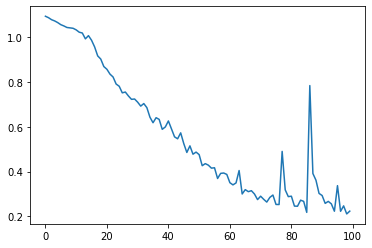

In [26]:
#Plotting the error.
plt.figure()
plt.plot(all_losses)

In [28]:
#Predict
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, feelings[category_index]))
            predictions.append([value, feelings[category_index]])

for i in range(5):
    predict(x_test[i])


> ['good']
(-0.82) 3
(-1.14) 2
(-1.43) 1

> ['really', 'team', 'promptly', 'nice']
(-0.01) 3
(-5.14) 1
(-5.53) 2

> ['small', 'slightly', 'stay', 'expensive']
(-0.10) 3
(-2.44) 2
(-4.93) 1

> ['approachable', 'easy', 'friendly', 'good', 'nice', 'decent']
(-0.04) 3
(-3.40) 2
(-4.88) 1

> ['clean', 'awesome', 'friendly', 'spoken', 'linen', 'front', 'soft']
(-0.00) 3
(-6.03) 1
(-7.04) 2
